# Explication du pipeline Grad-Eclip pour l'image avec CLIP

## Objectif du notebook

Ce notebook illustre comment exploiter les mécanismes internes du modèle **CLIP (Contrastive Language–Image Pretraining)** pour **visualiser les zones d’une image qui influencent le plus la similarité avec un texte donné**, via la méthode **Grad-ECLIP**.

## Sommaire du notebook

1. **Imports, initialisation et chargement du modèle CLIP**
2. **Prétraitement de l'image**
3. **Calcul de l'attention et encodage de l'image**
4. **Chargement et affichage de l'image, préparation des textes**
5. **Prétraitement image/texte et extraction des embeddings**
6. **Extraction des features intermédiaires pour l'explication**
7. **Fontions pour l'explicabilité : Gread-Eclip, ODAM, Grad-CAM**
8. **Applications et visualiations**

### 1. Imports, initialisation et chargement du modèle CLIP

In [10]:
#!pip install ftfy regex tqdm
#!pip install git+https://github.com/openai/CLIP.git


In [12]:
!pip3 install torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 37.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 29.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 41.6 MB/s eta 0:00:0000:010:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch-uncertainty 0.5.1 requires seaborn, which is not installed.
ogb 1.3.6 requires pandas>=0.24.0, which is not installed.
ogb 1.3.6 requires scikit-learn>=0.20.0, which is not installed.
torch-geometric 2.6.1 requires pyparsing, which is not installed.
gradio 4.29.0 requires altair<6.0,>=4.2.0, which is not installed.
gradio 4.29.0 requires importlib-resources<7.0,>=1.3, which is not installed.
gradio 4.29.0 requires matplotlib~=3.0, which is not installed.
gradio 4.29.0 requires

In [6]:
!pip install --upgrade open-clip-torch

In [1]:
import math
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, InterpolationMode
import clip
from open_clip import create_model_from_pretrained


import cv2
import numpy as np
    
device = "cpu" #"cuda" if torch.cuda.is_available() else "cpu"
clipmodel, preprocess = clip.load("ViT-B/16", device=device)
clip_inres = clipmodel.visual.input_resolution
clip_ksize = clipmodel.visual.conv1.kernel_size

print("[clip resolution]:", clip_inres)
print("[clip kernel size]:", clip_ksize)

[clip resolution]: 224
[clip kernel size]: (16, 16)


### 2. Prétraitement de l'image

In [2]:
# Définition du pipeline de prétraitement des images pour les adapter à CLIP
# CLIP attend des images normalisées selon des moyennes/écarts-types précis
def transform_clip(img):
    # Conversion en tenseur : valeurs entre 0 et 1, canaux RGB → CHW
    tensor = ToTensor()(img)

    # Normalisation avec les statistiques spécifiques à CLIP
    normalized = Normalize(
        mean=(0.48145466, 0.4578275, 0.40821073),
        std=(0.26862954, 0.26130258, 0.27577711)
    )(tensor)

    return normalized

def imgprocess(img, patch_size=[16, 16], scale_factor=1):
    """
    Redimensionne et normalise l'image pour la rendre compatible avec le patching CLIP.
    L'image est ajustée pour que ses dimensions soient des multiples du patch size.
    
    Args:
        img (PIL.Image): Image d'entrée
        patch_size (list): Taille des patches [hauteur, largeur]
        scale_factor (float): Facteur d'échelle pour le redimensionnement
        
    Returns:
        torch.Tensor: Image prétraitée et normalisée
    """
    # Taille originale de l'image
    w, h = img.size
    ph, pw = patch_size

    # Calcul de nouvelles dimensions compatibles avec le patching
    nw = ((w * scale_factor + pw - 1) // pw) * pw
    nh = ((h * scale_factor + ph - 1) // ph) * ph

    # Resize avec interpolation bicubique pour lisser l'image
    ResizeOp = Resize((nh, nw), interpolation=InterpolationMode.BICUBIC)

    # Retourne l'image prétraitée et normalisée
    return transform_clip(ResizeOp(img).convert("RGB"))


def visualize(map, raw_image, resize):
    """
    Superpose une heatmap (map) sur l'image d'origine (raw_image) après redimensionnement.
    Utilise une colormap pour mettre en évidence les zones importantes.
    
    Args:
        map (torch.Tensor): Heatmap à superposer
        raw_image (PIL.Image): Image d'origine
        resize (callable): Fonction de redimensionnement
        
    Returns:
        np.ndarray: Image RGB avec la heatmap superposée
    """
    # On convertit l'image en tableau NumPy
    image = np.asarray(raw_image.copy())
    
    # On redimensionne la heatmap et on la convertit en NumPy
    # .unsqueeze(0) ajoute une dimension de batch
    # [0] sélectionne le premier élément
    # .cpu() déplace le tenseur sur CPU
    # .numpy() convertit en tableau NumPy
    map = resize(map.unsqueeze(0))[0].cpu().numpy()
    
    # On convertit la heatmap en image couleur avec la colormap JET
    # *255 convertit les valeurs [0,1] en [0,255]
    # .astype(np.uint8) convertit en entiers non signés 8 bits
    color = cv2.applyColorMap((map*255).astype(np.uint8), cv2.COLORMAP_JET)
    
    # On convertit de BGR (OpenCV) à RGB (matplotlib)
    color = cv2.cvtColor(color, cv2.COLOR_BGR2RGB)
    
    # On superpose la heatmap sur l'image avec une transparence de 50%
    # np.clip s'assure que les valeurs restent dans [0,255]
    c_ret = np.clip(image * (1 - 0.5) + color * 0.5, 0, 255).astype(np.uint8)
    
    return c_ret



### 3. Calcul de l'attention et encodage de l'image

In [3]:

def reshape_for_multihead(x, tgt_len, bsz, num_heads, head_dim):
    """
    Réorganise un tenseur pour le calcul multi-têtes d'attention.
    Args:
        x (torch.Tensor): Tenseur d'entrée (q, k ou v)
        tgt_len (int): Longueur de séquence cible
        bsz (int): Taille du batch
        num_heads (int): Nombre de têtes
        head_dim (int): Dimension par tête
    Returns:
        torch.Tensor: Tenseur réorganisé pour multi-têtes
    """
    return x.contiguous().view(tgt_len, bsz * num_heads, head_dim).transpose(0, 1)


def attention_layer(q, k, v, num_heads=1):
    """
    Implémentation du Scaled Dot-Product Attention avec support multi-têtes (num_heads).
    Args:
        q, k, v (torch.Tensor): Tenseurs d'entrée (L, B, D)
        num_heads (int): Nombre de têtes d'attention
    Returns:
        attn_output (torch.Tensor): Sortie d'attention fusionnée (L, B, D)
        attn_output_weights (torch.Tensor): Poids d'attention moyens (B, L, L)
    """
    tgt_len, bsz, embed_dim = q.shape
    head_dim = embed_dim // num_heads
    scaling = float(head_dim) ** 0.5  # Forme équivalente plus explicite
    q = q * scaling

    # Reshape pour passage en multi-têtes : (B*num_heads, L, D_head)
    def reshape(x):
        return x.contiguous().view(tgt_len, bsz * num_heads, head_dim).transpose(0, 1)
    q, k, v = map(reshape, (q, k, v))

    # Calcul des poids d'attention
    attn_output_weights = torch.bmm(q, k.transpose(1, 2))  # (B*num_heads, L, L)
    attn_output_weights = F.softmax(attn_output_weights, dim=-1)

    # Application des poids sur les valeurs
    attn_output_heads = torch.bmm(attn_output_weights, v)
    assert attn_output_heads.shape == (bsz * num_heads, tgt_len, head_dim)

    # Remise en forme : fusion des têtes
    attn_output = attn_output_heads.transpose(0, 1).contiguous().view(tgt_len, bsz, embed_dim)

    # Moyenne des poids d'attention sur les têtes pour visualisation
    attn_output_weights = attn_output_weights.view(bsz, num_heads, tgt_len, -1).mean(dim=1)

    return attn_output, attn_output_weights


def clip_encode_dense(x, n):
    """
    Encode une image avec CLIP en interceptant les n derniers blocs Transformer.
    Permet d'extraire les features intermédiaires et les cartes d'attention pour l'explication.
    
    Args:
        x (torch.Tensor): Image d'entrée prétraitée
        n (int): Nombre de derniers blocs à intercepter
        
    Returns:
        tuple: (sortie finale, features, valeurs, queries, keys, attentions, sorties d'attention, taille de la carte)
    """
    # On récupère les paramètres du modèle
    # vision_width : dimension des features
    # vision_heads : nombre de têtes d'attention
    vision_width = clipmodel.visual.transformer.width
    vision_heads = vision_width // 64
    print("[vision_width and vision_heads]:", vision_width, vision_heads)
    
    # On convertit en demi-précision pour économiser la mémoire
    x = x.half()
    
    # Patch embedding : première couche convolutive
    # Cette couche découpe l'image en patches
    x = clipmodel.visual.conv1(x)
    
    # On récupère les dimensions spatiales des features
    feah, feaw = x.shape[-2:]
    
    # On réorganise les features pour le transformer
    # On aplatit les dimensions spatiales
    x = x.reshape(x.shape[0], x.shape[1], -1)
    # On permute les dimensions pour la forme attendue par le transformer
    x = x.permute(0, 2, 1)
    
    # On ajoute le token de classe (CLS)
    # On récupère l'embedding de classe
    class_embedding = clipmodel.visual.class_embedding.to(x.dtype)
    # On concatène l'embedding de classe avec les features d'image
    x = torch.cat([
        class_embedding + torch.zeros(x.shape[0], 1, x.shape[-1]).to(x),
        x
    ], dim=1)
    
    # On ajoute les embeddings positionnels
    # On récupère les embeddings positionnels
    pos_embedding = clipmodel.visual.positional_embedding.to(x.dtype)
    # On sépare le token CLS et les positions d'image
    tok_pos, img_pos = pos_embedding[:1, :], pos_embedding[1:, :]
    
    # On calcule les dimensions spatiales attendues
    pos_h = clip_inres // clip_ksize[0]
    pos_w = clip_inres // clip_ksize[1]
    
    # On vérifie que les dimensions correspondent
    assert img_pos.size(0) == (pos_h * pos_w), (
        f"pos_emb ({img_pos.size(0)}) != {pos_h}*{pos_w}"
    )
    
    # On réorganise les embeddings positionnels pour l'interpolation
    # On reshape pour avoir les dimensions spatiales
    img_pos = img_pos.reshape(1, pos_h, pos_w, img_pos.shape[1]).permute(0, 3, 1, 2)
    print("[POS shape]:", img_pos.shape, (feah, feaw))
    
    # On interpole les embeddings positionnels à la taille des features
    # On utilise l'interpolation bicubique pour la qualité
    img_pos = torch.nn.functional.interpolate(
        img_pos, 
        size=(feah, feaw), 
        mode='bicubic', 
        align_corners=False
    )
    
    # On réorganise pour la concaténation
    img_pos = img_pos.reshape(1, img_pos.shape[1], -1).permute(0, 2, 1)
    
    # On concatène les embeddings positionnels
    pos_embedding = torch.cat((tok_pos[None, ...], img_pos), dim=1)
    
    # On ajoute les embeddings positionnels aux features
    x = x + pos_embedding
    
    # On applique la normalisation de la première couche
    x = clipmodel.visual.ln_pre(x)
    
    # On permute les dimensions pour le transformer
    # NLD -> LND (batch, length, dim) -> (length, batch, dim)
    x = x.permute(1, 0, 2)
    
    # On passe dans tous les blocs sauf les n derniers
    x = torch.nn.Sequential(*clipmodel.visual.transformer.resblocks[:-n])(x)
    
    # On intercepte les n derniers blocs pour l'analyse
    attns = []  # Liste des matrices d'attention
    atten_outs = []  # Liste des sorties d'attention
    vs = []  # Liste des valeurs
    qs = []  # Liste des queries
    ks = []  # Liste des keys
    
    # On parcourt les n derniers blocs
    for TR in clipmodel.visual.transformer.resblocks[-n:]:
        # On sauvegarde l'entrée pour le skip connection
        x_in = x
        
        # On applique la première normalisation
        x = TR.ln_1(x_in)
        
        # On calcule les projections Q, K, V
        # On utilise la fonction linéaire de PyTorch
        linear = torch._C._nn.linear
        q, k, v = linear(x, TR.attn.in_proj_weight, TR.attn.in_proj_bias).chunk(3, dim=-1)
        
        # On calcule l'attention
        attn_output, attn = attention_layer(q, k, v, 1)  # vision_heads=1
        
        # On sauvegarde les résultats
        attns.append(attn)
        atten_outs.append(attn_output)
        vs.append(v)
        qs.append(q)
        ks.append(k)
        
        # On applique la projection de sortie
        x_after_attn = linear(attn_output, TR.attn.out_proj.weight, TR.attn.out_proj.bias)
        
        # On ajoute le skip connection
        x = x_after_attn + x_in
        
        # On applique le MLP
        x = x + TR.mlp(TR.ln_2(x))
    
    # On permute les dimensions pour la forme finale
    # LND -> NLD (length, batch, dim) -> (batch, length, dim)
    x = x.permute(1, 0, 2)
    
    # On applique la normalisation finale
    x = clipmodel.visual.ln_post(x)
    
    # On applique la projection finale
    x = x @ clipmodel.visual.proj
    
    return x, x_in, vs, qs, ks, attns, atten_outs, (feah, feaw)

### 4. Chargement et affichage de l'image, préparation des textes

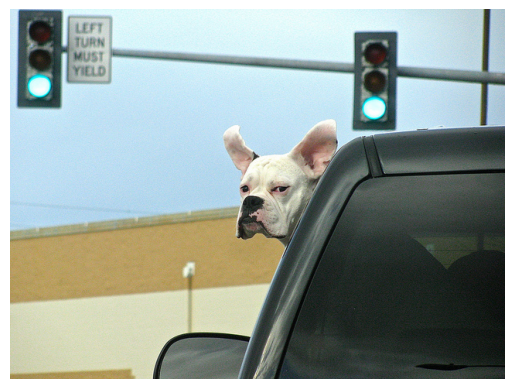

In [4]:
import os
from urllib.request import urlopen
import matplotlib.pyplot as plt
from PIL import Image

# Chargement d'une image locale
img_path = "./dog_and_car.png"
img = Image.open(img_path).convert("RGB")
texts = ["dog", "car", "traffic lights", "a dog in a car waiting for traffic lights"]

# Affichage de l'image
plt.imshow(img)
plt.axis('off')
plt.show()

### 5. Prétraitement image/texte et extraction des embeddings

In [8]:
# Prétraitement de l'image pour CLIP
img_preprocessed = preprocess(img).cuda().unsqueeze(0)
# Tokenization des textes
text_processed = clip.tokenize(texts).cuda()
# Extraction des embeddings texte
text_embedding = clipmodel.to("cuda").encode_text(text_processed.to("cuda"))
text_embedding = F.normalize(text_embedding, dim=-1)
print("[text embedding]:", text_embedding.shape)
# Extraction de l'embedding image original
ori_img_embedding = clipmodel.encode_image(img_preprocessed)
ori_img_embedding = F.normalize(ori_img_embedding, dim=-1)
print("[image embedding]:", ori_img_embedding.shape)
# Calcul de la similarité image/texte
cosine = (ori_img_embedding @ text_embedding.T)
print("[cosine]:", cosine)


[text embedding]: torch.Size([4, 512])
[image embedding]: torch.Size([1, 512])
[cosine]: tensor([[0.2681, 0.2379, 0.2606, 0.3506]], device='cuda:0',
       grad_fn=<MmBackward0>)


### 6. Extraction des features intermédiaires pour l'explication et calcul de similarité 

In [12]:
img_preprocessed_k = imgprocess(img).cuda().unsqueeze(0)
# Passage dans le pipeline dense pour obtenir les features et les cartes d'attention
outputs, last_feat, vs, qs, ks, attns, atten_outs, map_size = clip_encode_dense(img_preprocessed_k, n=1)
img_embedding = F.normalize(outputs[:,0], dim=-1)
print("[image embedding]:", img_embedding.shape)
cosine = (img_embedding @ text_embedding.T)[0]
print("cosine:", cosine)
# Similarité entre les patchs d'image et les textes
p_final = F.normalize(outputs[:,1:], dim=-1)
cosine_p = (p_final @ text_embedding.T)[0].transpose(1,0).reshape(-1, *map_size)
print("[position similarity (cosine p)]:", cosine_p.shape)

[vision_width and vision_heads]: 768 12


RuntimeError: Input type (torch.cuda.HalfTensor) and weight type (torch.cuda.FloatTensor) should be the same

### 7. Fontions pour l'explicabilité : Gread-Eclip, ODAM, Grad-CAM

In [ ]:
def sim_qk(q, k):
    """
    Calcule la similarité cosinus entre le token CLS (classe) et tous les patchs d'image.
    Utilisé pour pondérer l'importance spatiale dans Grad-Eclip.
    
    Args:
        q (torch.Tensor): Tenseur Query
        k (torch.Tensor): Tenseur Key
        
    Returns:
        torch.Tensor: Similarités cosinus normalisées
    """
    # On extrait le token CLS (premier token) et on le normalise
    # [:1,0,:] sélectionne le premier token du premier élément du batch
    # F.normalize() normalise le vecteur (norme L2 = 1)
    q_cls = F.normalize(q[:1,0,:], dim=-1)
    
    # On extrait les tokens des patchs d'image et on les normalise
    # [1:,0,:] sélectionne tous les tokens sauf le premier du premier élément du batch
    k_patch = F.normalize(k[1:,0,:], dim=-1)
    
    # On calcule la similarité cosinus entre le token CLS et chaque patch
    # On fait le produit élémentaire et on somme sur la dernière dimension
    cosine_qk = (q_cls * k_patch).sum(-1)
    
    # On normalise les similarités entre 0 et 1
    # On calcule le minimum et le maximum
    cosine_qk_max = cosine_qk.max(dim=-1, keepdim=True)[0]
    cosine_qk_min = cosine_qk.min(dim=-1, keepdim=True)[0]
    # On normalise par min-max
    cosine_qk = (cosine_qk-cosine_qk_min) / (cosine_qk_max-cosine_qk_min)
    
    return cosine_qk


def grad_eclip(c, qs, ks, vs, attn_outputs, map_size):
    """
    Calcule la carte d'explication Grad-Eclip pour l'image.
    Combine le gradient, les valeurs d'attention et la similarité QK pour chaque bloc.
    
    Args:
        c (torch.Tensor): Score de similarité image/texte
        qs (list): Liste des tenseurs Query
        ks (list): Liste des tenseurs Key
        vs (list): Liste des tenseurs Value
        attn_outputs (list): Liste des sorties d'attention
        map_size (tuple): Taille spatiale de la carte
        
    Returns:
        torch.Tensor: Carte d'explication Grad-Eclip
    """
    # Liste pour stocker les cartes d'explication de chaque bloc
    tmp_maps = []
    
    # On parcourt les blocs en parallèle
    for q, k, v, attn_output in zip(qs, ks, vs, attn_outputs):
        # On calcule le gradient du score par rapport à la sortie d'attention
        # retain_graph=True permet de réutiliser le graphe de calcul
        grad = torch.autograd.grad(
            c,
            attn_output,
            retain_graph=True)[0]
        
        # On extrait le gradient du token CLS
        # [:1,0,:] sélectionne le premier token du premier élément du batch
        grad_cls = grad[:1,0,:]
        
        # On extrait les valeurs des patchs d'image
        # [1:,0,:] sélectionne tous les tokens sauf le premier
        v_patch = v[1:,0,:]
        
        # On calcule la similarité QK pour pondérer l'importance
        # .reshape(-1) aplatit le tenseur
        cosine_qk = sim_qk(q, k).reshape(-1)
        
        # On combine gradient, valeurs et similarité
        # grad_cls * v_patch : importance des features
        # cosine_qk[:,None] : pondération par similarité
        # .sum(-1) : somme sur la dimension des features
        tmp_maps.append((grad_cls * v_patch * cosine_qk[:,None]).sum(-1))
    
    # On empile les cartes et on fait la somme
    # F.relu_() : on garde uniquement les valeurs positives
    # .sum(0) : somme sur la dimension des blocs
    emap = F.relu_(torch.stack(tmp_maps, dim=0)).sum(0)
    
    # On redimensionne à la taille spatiale de l'image
    return emap.reshape(*map_size)


def self_attn(attns, map_size):
    """
    Calcule la carte d'attention self du token CLS sur tous les patchs d'image.
    
    Args:
        attns (list): Liste des matrices d'attention
        map_size (tuple): Taille spatiale de la carte
        
    Returns:
        torch.Tensor: Carte d'attention self
    """
    # On prend la dernière matrice d'attention
    # [0,:1,1:] sélectionne l'attention du token CLS sur les patchs
    # .reshape(*map_size) redimensionne à la taille spatiale
    attn_patch = attns[-1][0,:1,1:].reshape(*map_size)
    
    # On affiche la forme de la carte
    print("[attn of cls token on lastv]:", attn_patch.shape)
    
    return attn_patch


def grad_cam(c, feat, map_size):
    """
    Calcule la carte d'explication Grad-CAM.
    Utilise les gradients sur les features pour pondérer l'importance spatiale.
    
    Args:
        c (torch.Tensor): Score de similarité image/texte
        feat (torch.Tensor): Features de la dernière couche
        map_size (tuple): Taille spatiale de la carte
        
    Returns:
        torch.Tensor: Carte d'explication Grad-CAM
    """
    # On calcule le gradient du score par rapport aux features
    grad = torch.autograd.grad(
        c,
        feat,
        retain_graph=True)[0]
    
    # On calcule le poids moyen du gradient sur la dimension des features
    # keepdim=True conserve la dimension pour la multiplication
    grad_weight = grad.mean(0, keepdim=True)
    
    # On calcule la carte d'activation pondérée
    # (grad_weight * feat) : importance des features
    # .sum(-1) : somme sur la dimension des features
    # F.relu_() : on garde uniquement les valeurs positives
    grad_cam = F.relu_((grad_weight * feat).sum(-1))
    
    # On redimensionne à la taille spatiale de l'image
    # [1:] : on ignore le token CLS
    grad_cam = grad_cam[1:].reshape(*map_size)
    
    return grad_cam

### 8. Applications et visualiations

['dog', 'car', 'traffic lights', 'a dog in a car waiting for traffic lights']


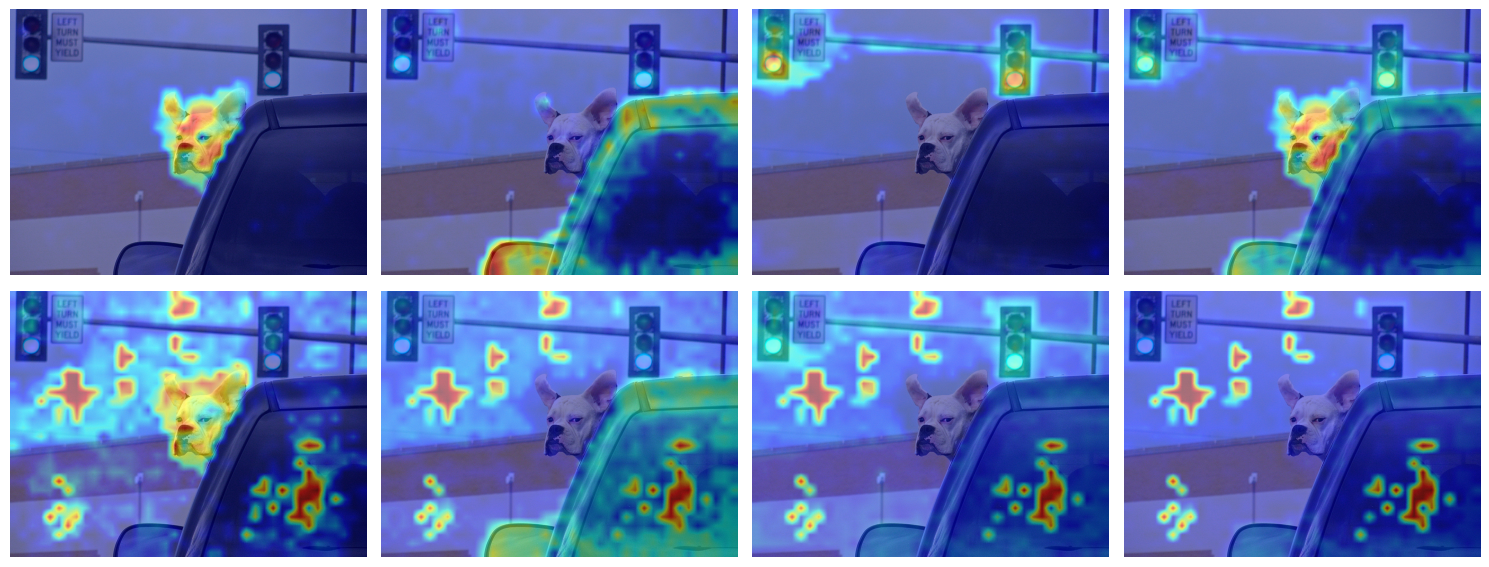

In [ ]:
# On prépare les listes pour stocker les cartes Grad-Eclip et Grad-CAM
# pour chaque texte (classe ou description)
grad_emaps = []
grad_cams = []
# Pour chaque score de similarité image/texte, on calcule les cartes d'explication
for i, c in enumerate(cosine):
    # Carte Grad-Eclip pour la classe/texte i
    grad_emaps.append(grad_eclip(c, qs, ks, vs, atten_outs, map_size))
    # Carte Grad-CAM pour la classe/texte i
    grad_cams.append(grad_cam(c, last_feat, map_size))

# Affichage des textes associés aux explications
print(texts)
# On récupère la taille de l'image pour le redimensionnement des heatmaps
h, w = img.size
resize = T.Resize((w, h))
# On crée une figure matplotlib avec 2 lignes (Grad-Eclip, Grad-CAM) et autant de colonnes que de textes
fig, axs = plt.subplots(ncols=len(cosine), nrows=2, figsize=(15, 6))
for i, ax in enumerate(axs.T):
    # Visualisation Grad-Eclip
    tmp = grad_emaps[i].clone()
    tmp -= tmp.min()
    tmp /= tmp.max()
    c_ret = visualize(tmp.detach().cpu(), img, resize)
    ax[0].axis('off')
    ax[0].imshow(c_ret)

    # Visualisation Grad-CAM
    tmp = grad_cams[i].clone()
    tmp -= tmp.min()
    tmp /= tmp.max()
    c_ret = visualize(tmp.detach().cpu(), img, resize)
    ax[1].axis('off')
    ax[1].imshow(c_ret)

# Ajustement de la mise en page pour éviter le chevauchement
fig.tight_layout() 